# Comparing Algorithms: A* vs Dijkstra on the City's Map

In [1]:
import osmnx as ox
import networkx as nx
import random
import heapq
import imageio
import os

## Libraries to animate the analysis
import matplotlib.pyplot as plt

### Importing and cleaning the map

In [2]:
place_name = "La Paz, Bolivia"
G = ox.graph_from_place(place_name, network_type="drive")

In [3]:
for edge in G.edges:
    # Cleaning the "maxspeed" attribute, some values are lists, some are strings, some are None
    maxspeed = 40
    if "maxspeed" in G.edges[edge]:
        maxspeed = G.edges[edge]["maxspeed"]
        if type(maxspeed) == list:
            speeds = [ int(speed) for speed in maxspeed ]
            maxspeed = min(speeds)
        elif type(maxspeed) == str:
            maxspeed = maxspeed.split(" ")
            maxspeed = int(maxspeed[0])
    G.edges[edge]["maxspeed"] = maxspeed
    # Adding the "weight" attribute (time = distance / speed)
    G.edges[edge]["weight"] = G.edges[edge]["length"] / maxspeed

### Visual utils

In [4]:
def style_unvisited_edge(edge):        
    G.edges[edge]["color"] = "#d36206"
    G.edges[edge]["alpha"] = 0.2
    G.edges[edge]["linewidth"] = 0.5

def style_visited_edge(edge):
    G.edges[edge]["color"] = "#d36206"
    G.edges[edge]["alpha"] = 1
    G.edges[edge]["linewidth"] = 1

def style_active_edge(edge):
    G.edges[edge]["color"] = '#e8a900'
    G.edges[edge]["alpha"] = 1
    G.edges[edge]["linewidth"] = 1

def style_path_edge(edge):
    G.edges[edge]["color"] = "white"
    G.edges[edge]["alpha"] = 1
    G.edges[edge]["linewidth"] = 1

In [5]:
def plot_graph():
    ox.plot_graph(
        G,
        node_size =  [ G.nodes[node]["size"] for node in G.nodes ],
        edge_color = [ G.edges[edge]["color"] for edge in G.edges ],
        edge_alpha = [ G.edges[edge]["alpha"] for edge in G.edges ],
        edge_linewidth = [ G.edges[edge]["linewidth"] for edge in G.edges ],
        node_color = "white",
        bgcolor = "#18080e",
        figsize=(20,20)
    )

In [6]:
def plot_heatmap(algorithm):
    edge_colors = ox.plot.get_edge_colors_by_attr(G, f"{algorithm}_uses", cmap="hot")
    fig, _ = ox.plot_graph(
        G,
        node_size = 0,
        edge_color = edge_colors,
        # bgcolor="#9a9745"
        bgcolor = "#18080e"
    )

## Algorithms implementation

In [7]:
def plot_state(step):
    fig, ax = ox.plot_graph(
        G,
        node_size =  [ G.nodes[node]["size"] for node in G.nodes ],
        edge_color = [ G.edges[edge]["color"] for edge in G.edges ],
        edge_alpha = [ G.edges[edge]["alpha"] for edge in G.edges ],
        edge_linewidth = [ G.edges[edge]["linewidth"] for edge in G.edges ],
        node_color = "white",
        bgcolor = "#18080e",
        figsize=(20,20),
    )
    plt.savefig(f"frames/frame_{step:03d}.png")
    plt.close()

In [8]:
def dijkstra(orig, dest, plot=False):
    for node in G.nodes:
        G.nodes[node]["visited"] = False
        G.nodes[node]["distance"] = float("inf")
        G.nodes[node]["previous"] = None
        G.nodes[node]["size"] = 0
    for edge in G.edges:
        style_unvisited_edge(edge)
    G.nodes[orig]["distance"] = 0
    G.nodes[orig]["size"] = 50
    G.nodes[dest]["size"] = 50
    pq = [(0, orig)]
    step = 0
    while pq:
        _, node = heapq.heappop(pq)
        if node == dest:
            if plot:
                print("Iteraciones:", step)
                plot_graph()
            return
        if G.nodes[node]["visited"]: continue
        G.nodes[node]["visited"] = True
        for edge in G.out_edges(node):
            style_visited_edge((edge[0], edge[1], 0))
            neighbor = edge[1]
            weight = G.edges[(edge[0], edge[1], 0)]["weight"]
            if G.nodes[neighbor]["distance"] > G.nodes[node]["distance"] + weight:
                G.nodes[neighbor]["distance"] = G.nodes[node]["distance"] + weight
                G.nodes[neighbor]["previous"] = node
                heapq.heappush(pq, (G.nodes[neighbor]["distance"], neighbor))
                for edge2 in G.out_edges(neighbor):
                    style_active_edge((edge2[0], edge2[1], 0))
        # plot_state(step)
        step += 1 

In [9]:
def distance(node1, node2):
    x1, y1 = G.nodes[node1]["x"], G.nodes[node1]["y"]
    x2, y2 = G.nodes[node2]["x"], G.nodes[node2]["y"]
    return ((x2 - x1)**2 + (y2 - y1)**2)**0.5

def a_star(orig, dest, plot=False):
    for node in G.nodes:
        G.nodes[node]["previous"] = None
        G.nodes[node]["size"] = 0
        G.nodes[node]["g_score"] = float("inf")
        G.nodes[node]["f_score"] = float("inf")
    for edge in G.edges:
        style_unvisited_edge(edge)
    G.nodes[orig]["size"] = 50
    G.nodes[dest]["size"] = 50
    G.nodes[orig]["g_score"] = 0
    G.nodes[orig]["f_score"] = distance(orig, dest)
    pq = [(G.nodes[orig]["f_score"], orig)]
    step = 0
    while pq:
        _, node = heapq.heappop(pq)
        if node == dest:
            if plot:
                print("Iteraciones:", step)
                plot_graph()
            return
        for edge in G.out_edges(node):
            style_visited_edge((edge[0], edge[1], 0))
            neighbor = edge[1]
            tentative_g_score = G.nodes[node]["g_score"] + distance(node, neighbor)
            if tentative_g_score < G.nodes[neighbor]["g_score"]:
                G.nodes[neighbor]["previous"] = node
                G.nodes[neighbor]["g_score"] = tentative_g_score
                G.nodes[neighbor]["f_score"] = tentative_g_score + distance(neighbor, dest)
                heapq.heappush(pq, (G.nodes[neighbor]["f_score"], neighbor))
                for edge2 in G.out_edges(neighbor):
                    style_active_edge((edge2[0], edge2[1], 0))
        step += 1

In [10]:
def reconstruct_path(orig, dest, plot=False, algorithm=None):
    for edge in G.edges:
        style_unvisited_edge(edge)
    dist = 0
    speeds = []
    curr = dest
    while curr != orig:
        prev = G.nodes[curr]["previous"]
        dist += G.edges[(prev, curr, 0)]["length"]
        speeds.append(G.edges[(prev, curr, 0)]["maxspeed"])
        style_path_edge((prev, curr, 0))
        if algorithm:
            G.edges[(prev, curr, 0)][f"{algorithm}_uses"] = G.edges[(prev, curr, 0)].get(f"{algorithm}_uses", 0) + 1
        curr = prev
    dist /= 1000
    if plot:
        print(f"Distance: {dist}")
        print(f"Avg. speed: {sum(speeds)/len(speeds)}")
        print(f"Total time: {dist/(sum(speeds)/len(speeds)) * 60}")
        plot_graph()

## Experiment 1

In [11]:
start = random.choice(list(G.nodes))
end = random.choice(list(G.nodes))

Iteraciones: 9146


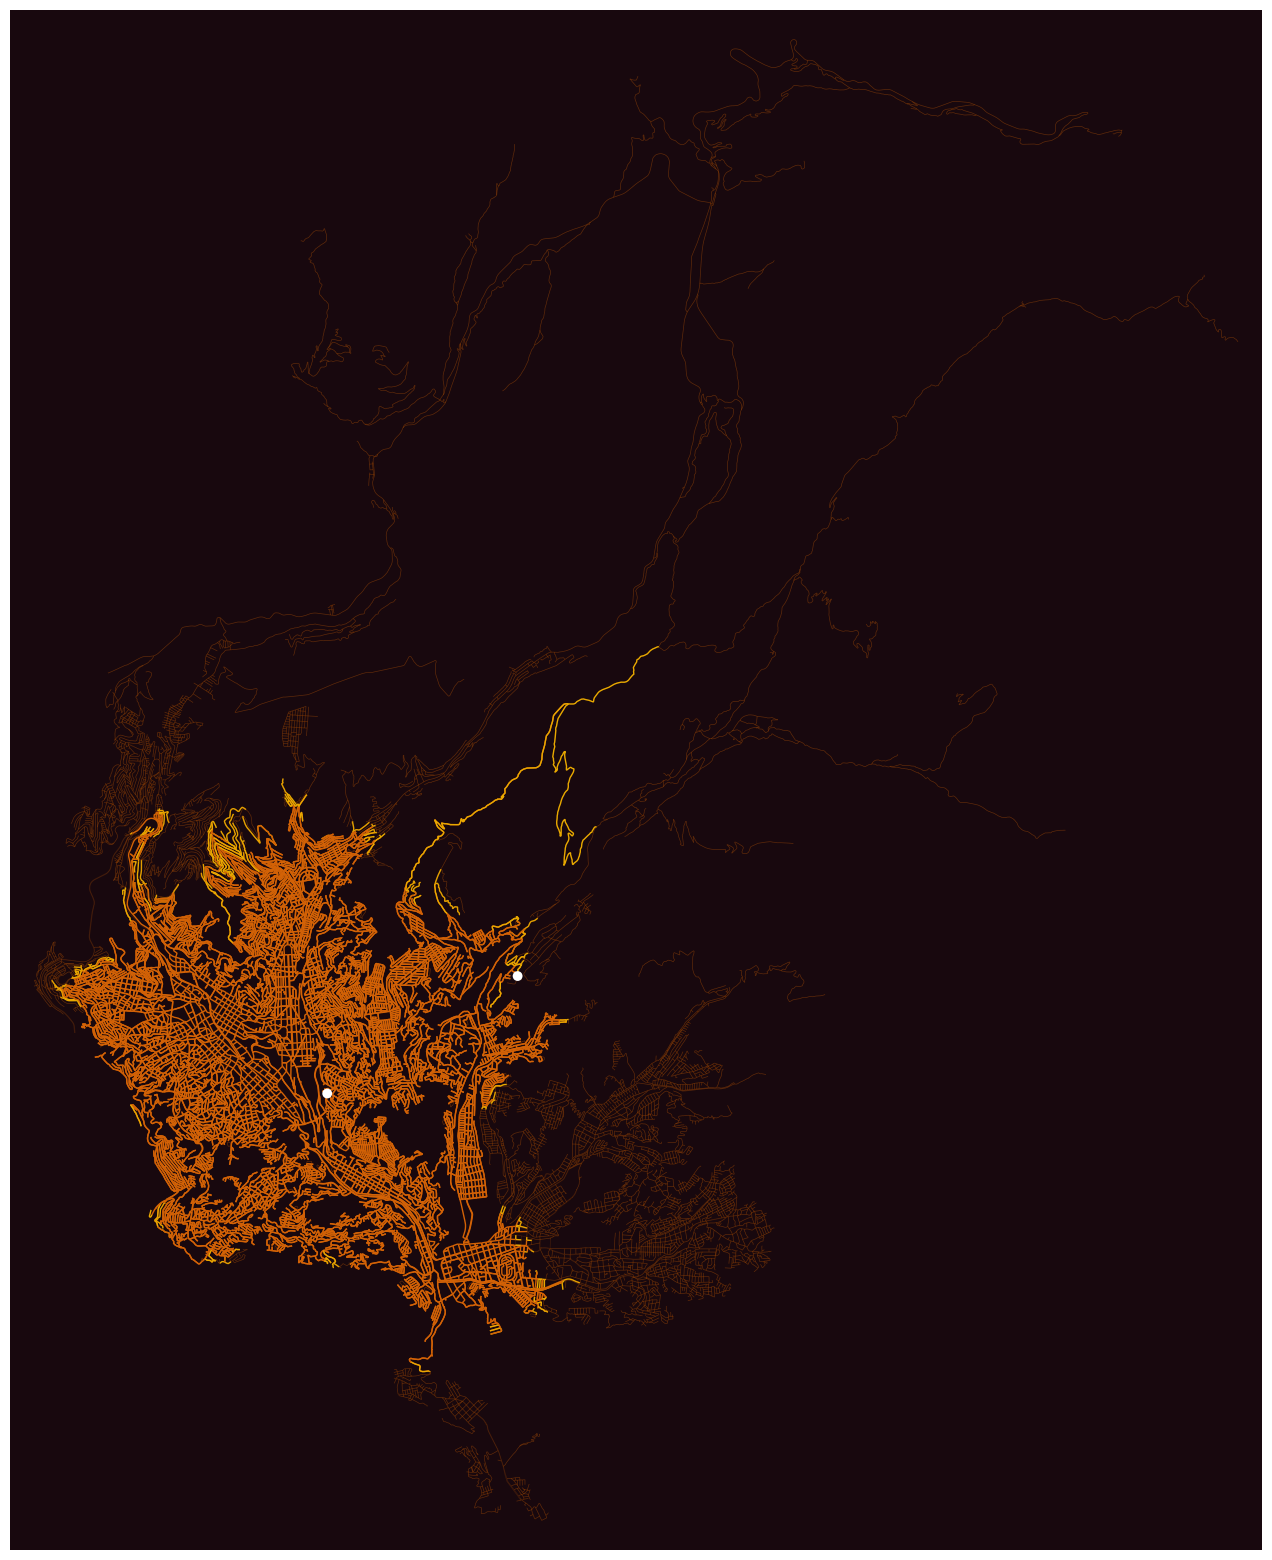

In [12]:
dijkstra(start, end, plot=True)

Distance: 7.3459319999999995
Avg. speed: 40.0
Total time: 11.018898


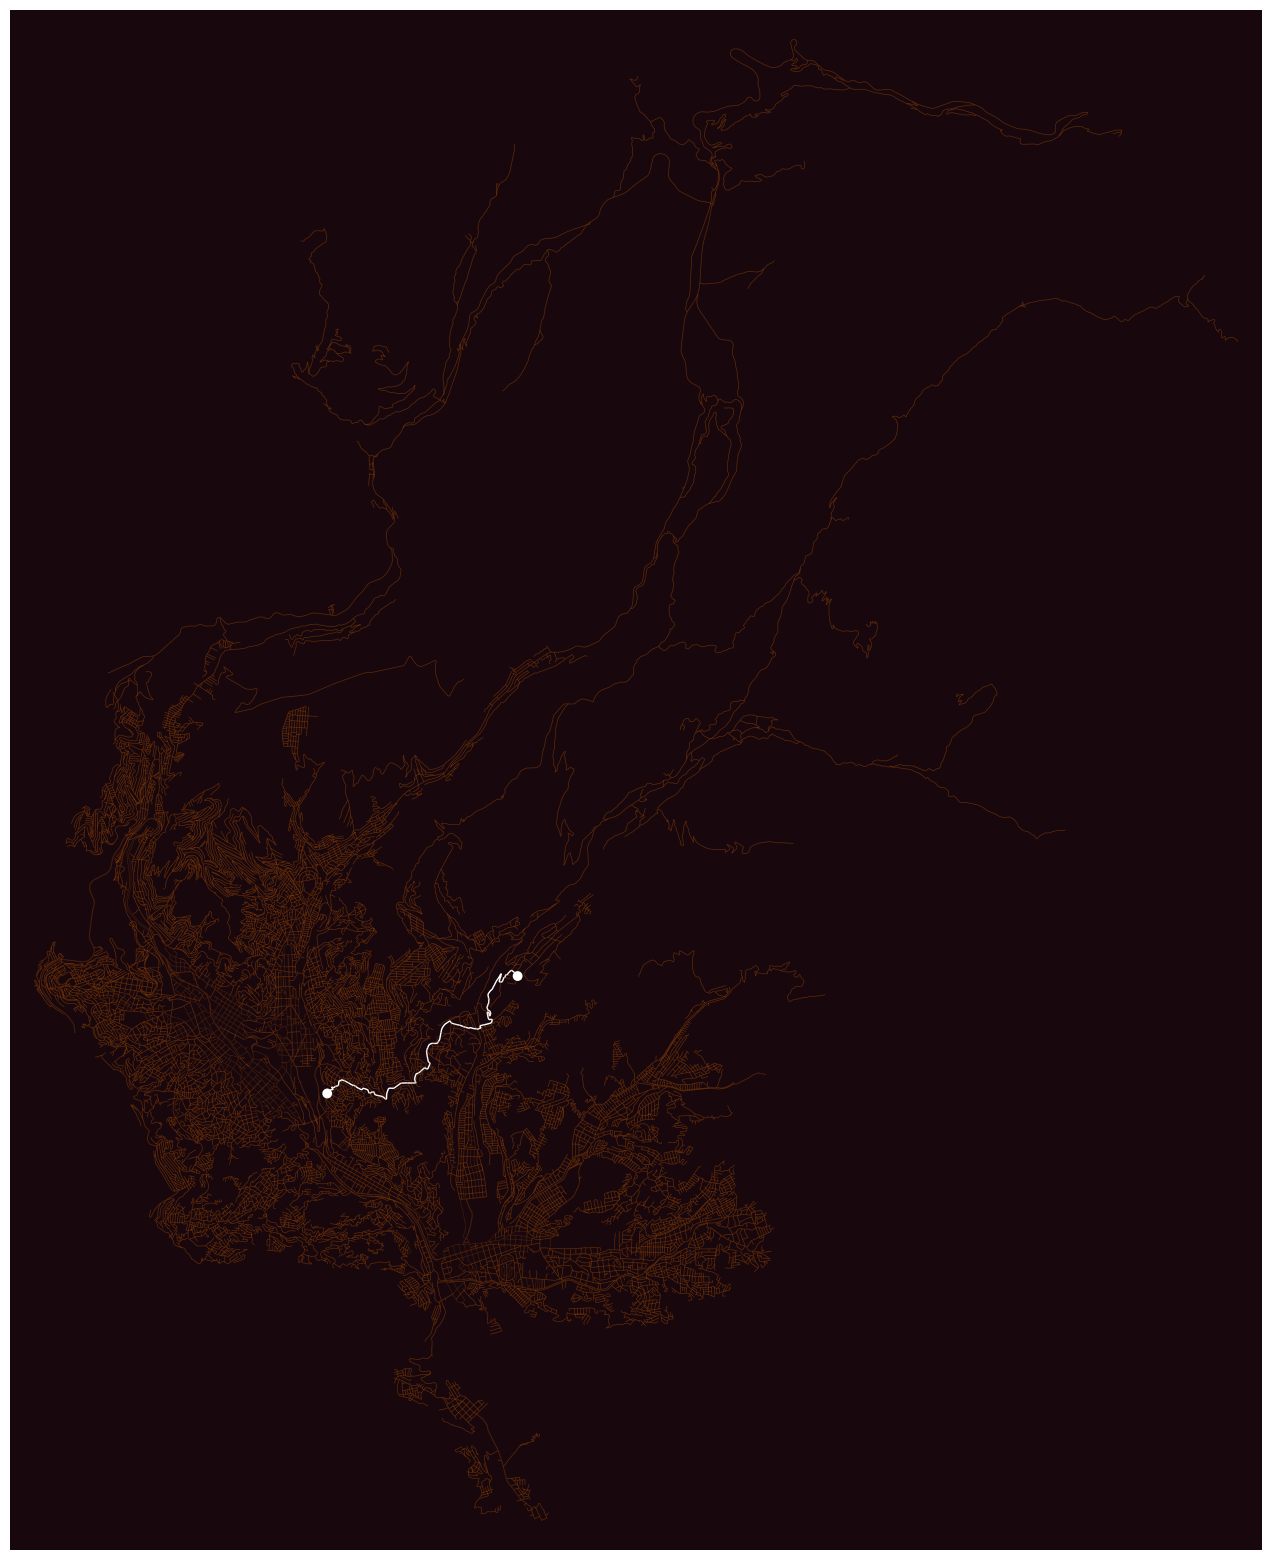

In [13]:
reconstruct_path(start, end, plot=True)

Iteraciones: 1554


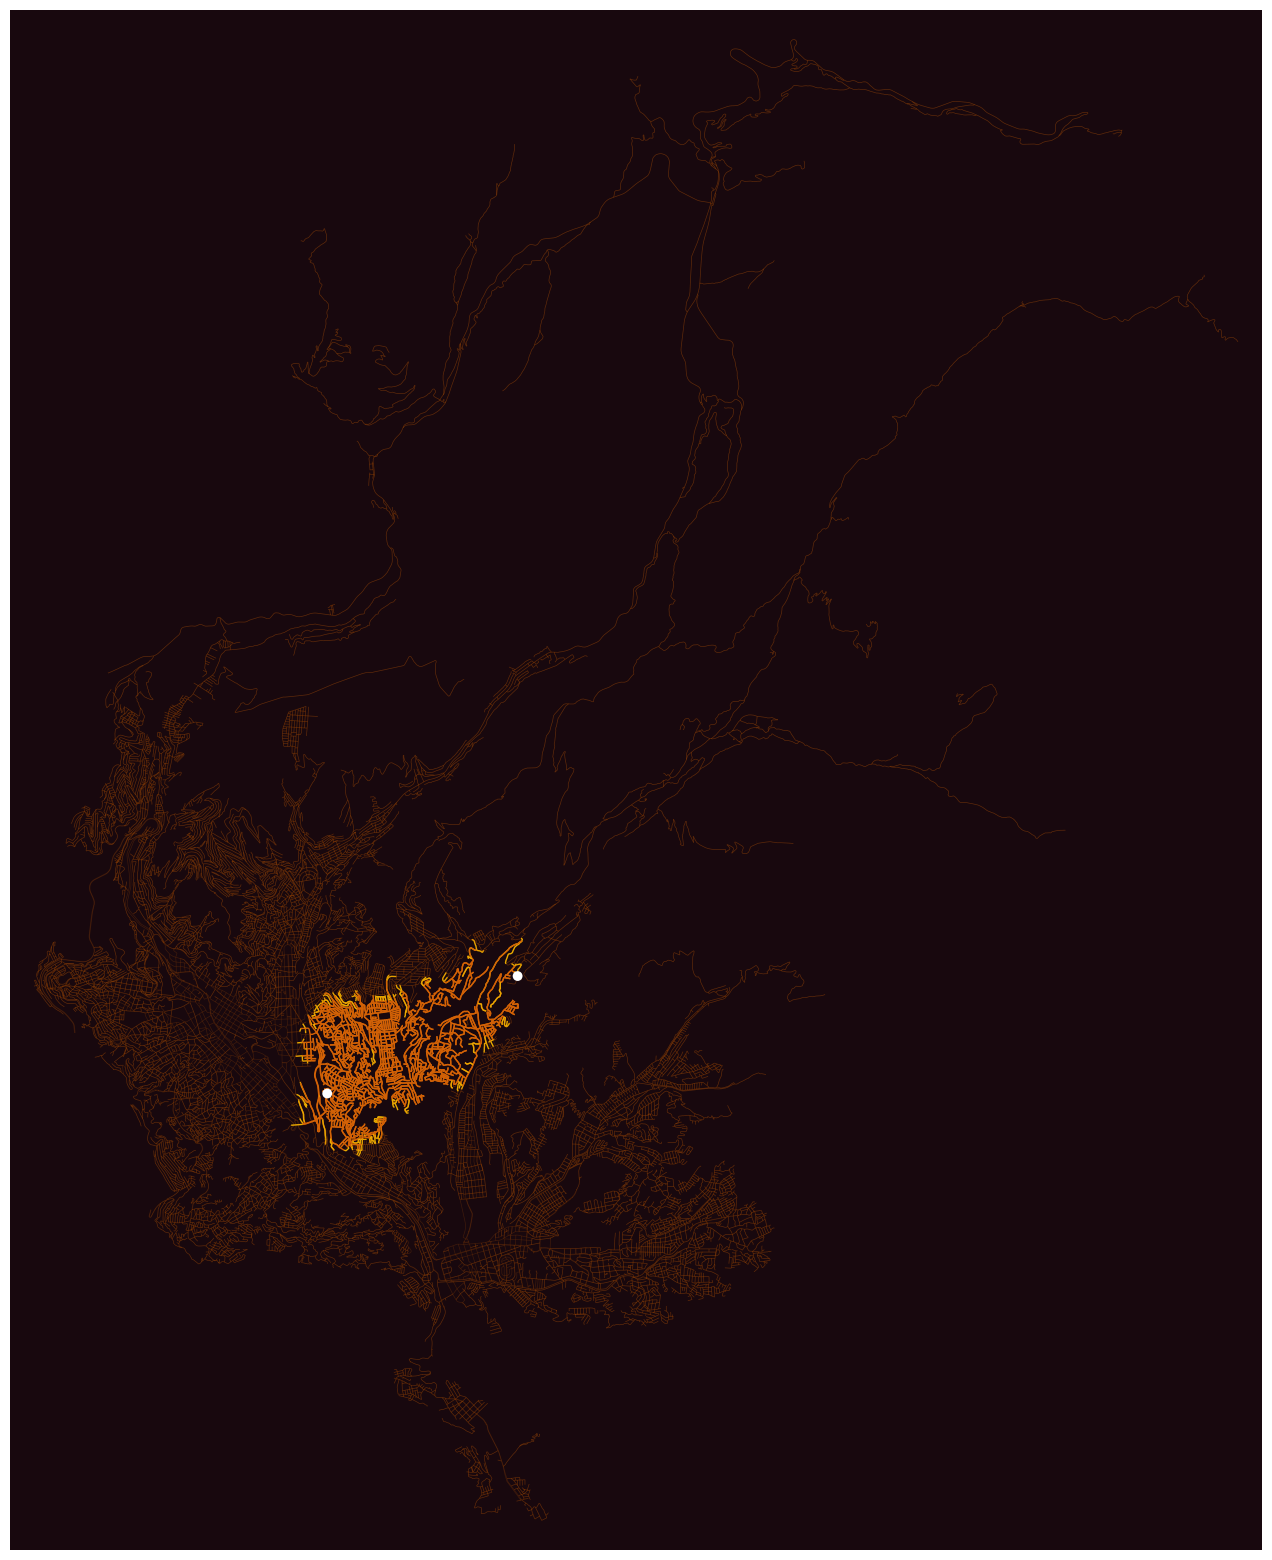

In [14]:
a_star(start, end, plot=True)

Distance: 7.3459319999999995
Avg. speed: 40.0
Total time: 11.018898


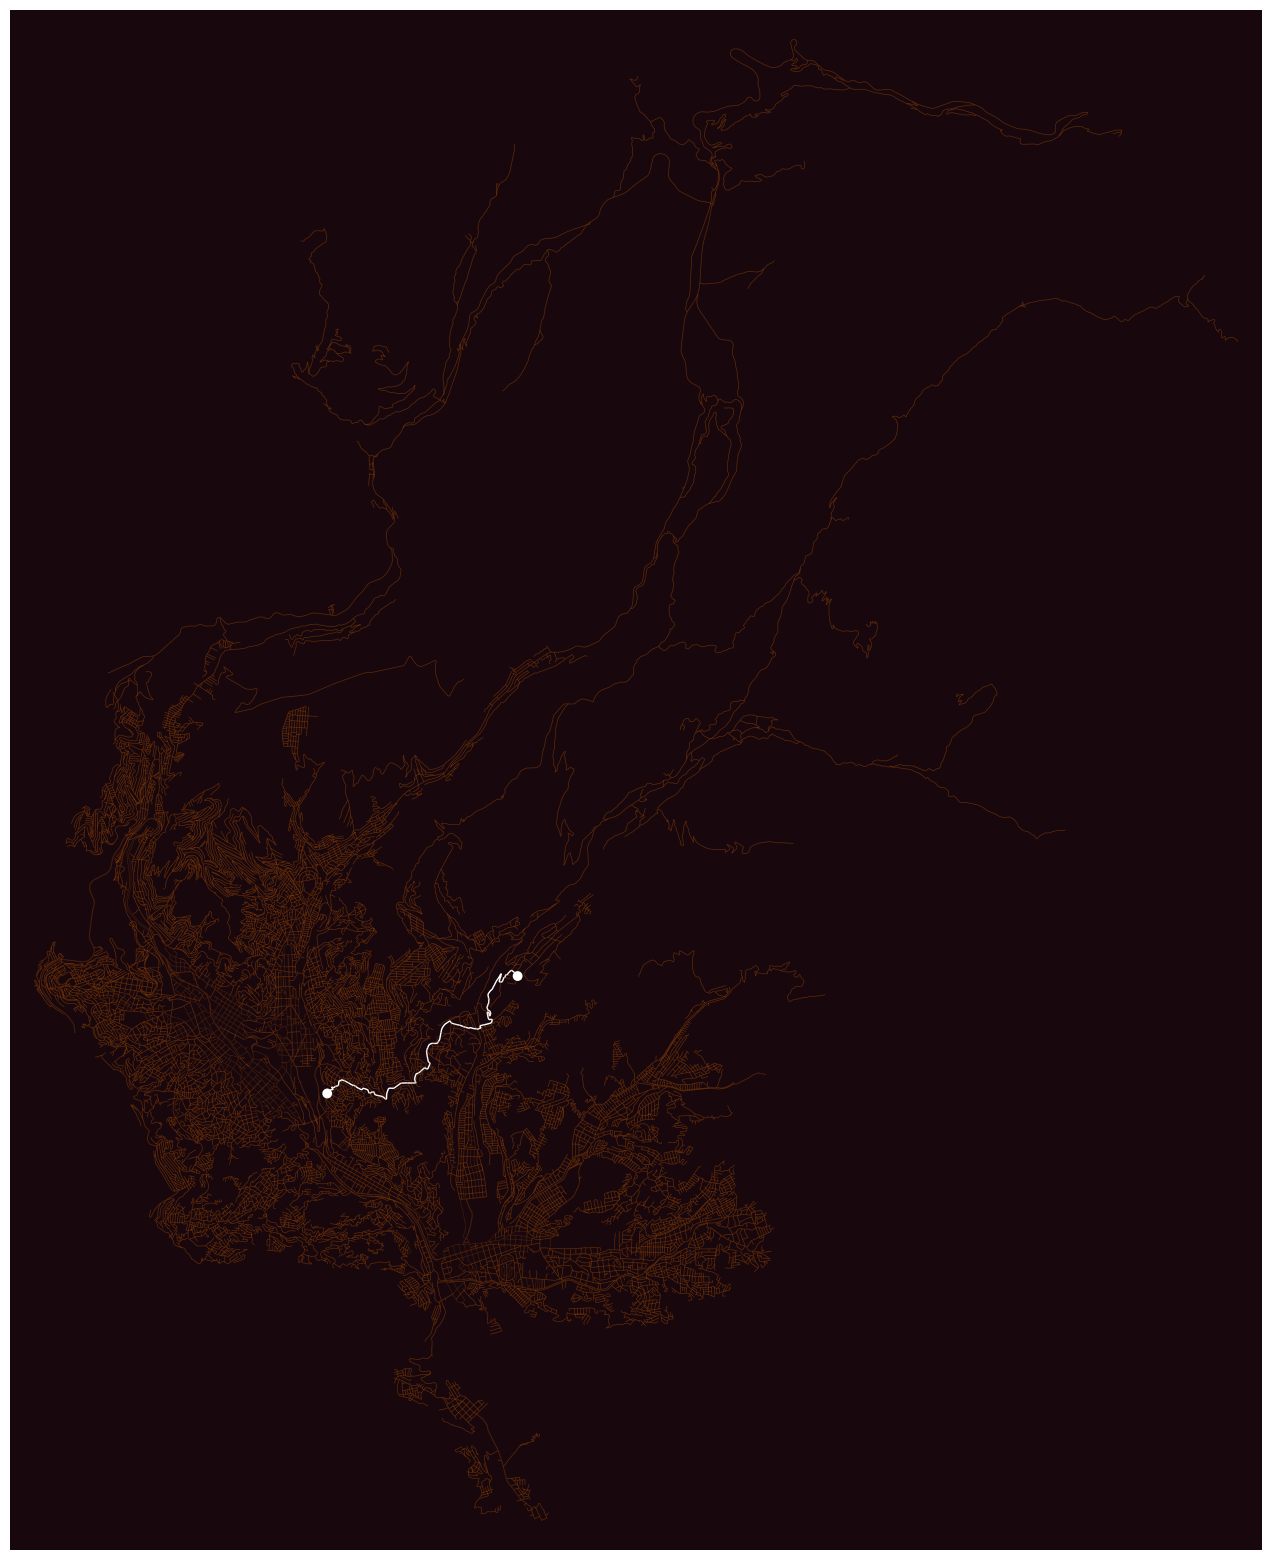

In [15]:
reconstruct_path(start, end, plot=True)

## Experiment 2

In [16]:
N = 100 # times to run each algorithm
for edge in G.edges:
    G.edges[edge]["dijkstra_uses"] = 0
    G.edges[edge]["a_star_uses"] = 0

In [17]:
for _ in range(N): # (might take a while, depending on N)
    start = random.choice(list(G.nodes))
    end = random.choice(list(G.nodes))
    dijkstra(start, end)
    reconstruct_path(start, end, algorithm="dijkstra")
    a_star(start, end)
    reconstruct_path(start, end, algorithm="a_star")

KeyError: None

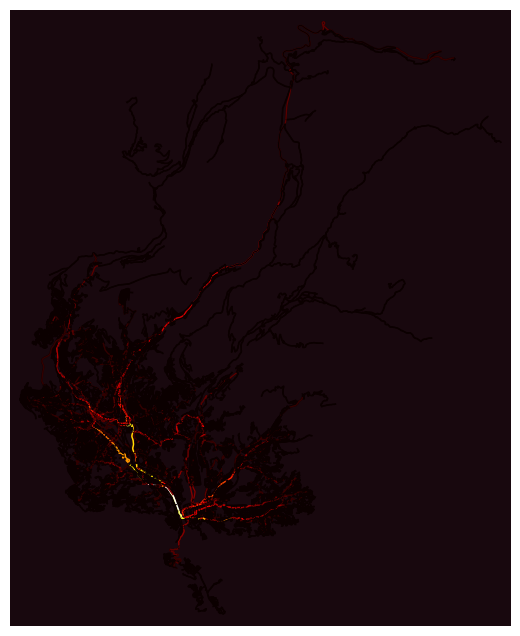

In [ ]:
plot_heatmap("dijkstra")

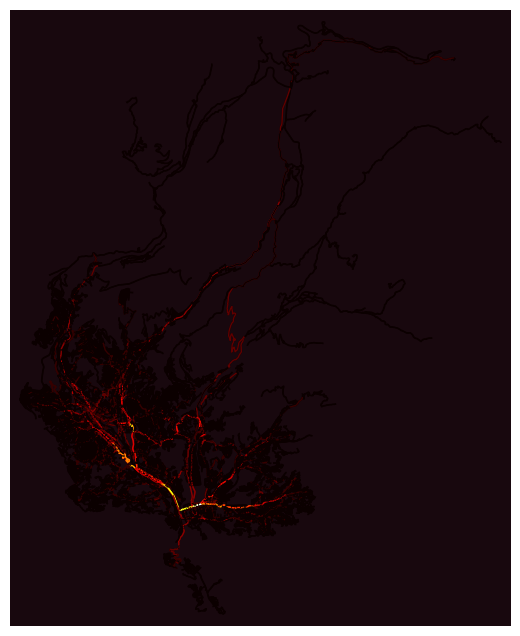

In [ ]:
plot_heatmap("a_star")

In [18]:
def dijkstra_modified(orig, dest, plot=False):
    explored_nodes = 0  # Para contar los nodos explorados
    for node in G.nodes:
        G.nodes[node]["visited"] = False
        G.nodes[node]["distance"] = float("inf")
        G.nodes[node]["previous"] = None
        G.nodes[node]["size"] = 0
    for edge in G.edges:
        style_unvisited_edge(edge)
    G.nodes[orig]["distance"] = 0
    G.nodes[orig]["size"] = 50
    G.nodes[dest]["size"] = 50
    pq = [(0, orig)]
    step = 0
    while pq:
        _, current = heapq.heappop(pq)
        if G.nodes[current]["visited"]:
            continue
        G.nodes[current]["visited"] = True
        explored_nodes += 1  # Incrementando los nodos explorados
        if current == dest:
            break
        for edge in G.out_edges(current):
            style_visited_edge((edge[0], edge[1], 0))
            neighbor = edge[1]
            weight = G.edges[(edge[0], edge[1], 0)]["weight"]
            if G.nodes[neighbor]["distance"] > G.nodes[current]["distance"] + weight:
                G.nodes[neighbor]["distance"] = G.nodes[current]["distance"] + weight
                G.nodes[neighbor]["previous"] = current
                heapq.heappush(pq, (G.nodes[neighbor]["distance"], neighbor))
        step += 1
    if plot:
        print("Iteraciones:", step)
        plot_graph()
    # Reconstruct path
    path = []
    current = dest
    total_distance = 0  # Acumular distancia
    speeds = []  # Velocidades para calcular promedio
    while current != orig:
        path.append(current)
        prev = G.nodes[current]["previous"]
        if prev is None:  # Si no hay ruta, rompe el ciclo
            break
        edge_data = G.get_edge_data(prev, current, 0)
        total_distance += edge_data['length'] / 1000  # Convertir a kilómetros
        speeds.append(edge_data['maxspeed'])
        current = prev
    path.append(orig)
    path.reverse()
    
    avg_speed = sum(speeds) / len(speeds) if speeds else 0
    total_time = total_distance / avg_speed * 60 if avg_speed else 0  # Convertir a minutos

    return path, explored_nodes, total_distance, avg_speed, total_time


def a_star_modified(orig, dest, plot=False):
    explored_nodes = 0  # Para contar los nodos explorados
    for node in G.nodes:
        G.nodes[node]["previous"] = None
        G.nodes[node]["g_score"] = float("inf")
        G.nodes[node]["f_score"] = float("inf")
        G.nodes[node]["size"] = 0
    for edge in G.edges:
        style_unvisited_edge(edge)
    G.nodes[orig]["size"] = 50
    G.nodes[dest]["size"] = 50
    G.nodes[orig]["g_score"] = 0
    G.nodes[orig]["f_score"] = distance(orig, dest)
    pq = [(G.nodes[orig]["f_score"], orig)]
    step = 0
    while pq:
        _, current = heapq.heappop(pq)
        if current == dest:
            break
        explored_nodes += 1  # Incrementando los nodos explorados
        for edge in G.out_edges(current):
            style_visited_edge((edge[0], edge[1], 0))
            neighbor = edge[1]
            tentative_g_score = G.nodes[current]["g_score"] + distance(current, neighbor)
            if tentative_g_score < G.nodes[neighbor]["g_score"]:
                G.nodes[neighbor]["previous"] = current
                G.nodes[neighbor]["g_score"] = tentative_g_score
                G.nodes[neighbor]["f_score"] = tentative_g_score + distance(neighbor, dest)
                heapq.heappush(pq, (G.nodes[neighbor]["f_score"], neighbor))
        step += 1
    if plot:
        print("Iteraciones:", step)
        plot_graph()
    
    path = []
    current = dest
    total_distance = 0  # Acumular distancia
    speeds = []  # Velocidades para calcular promedio
    while current != orig:
        path.append(current)
        prev = G.nodes[current]["previous"]
        if prev is None:  # Si no hay ruta, rompe el ciclo
            break
        edge_data = G.get_edge_data(prev, current, 0)
        total_distance += edge_data['length'] / 1000  # Convertir a kilómetros
        speeds.append(edge_data['maxspeed'])
        current = prev
    path.append(orig)
    path.reverse()
    
    avg_speed = sum(speeds) / len(speeds) if speeds else 0
    total_time = total_distance / avg_speed * 60 if avg_speed else 0  # Convertir a minutos

    return path, explored_nodes, total_distance, avg_speed, total_time


In [19]:
results = {
    'Dijkstra': {'times': [], 'explored_nodes': [], 'distances': [], 'avg_speeds': [], 'total_times': []},
    'A*': {'times': [], 'explored_nodes': [], 'distances': [], 'avg_speeds': [], 'total_times': []}
}


Text(0, 0.5, 'Número de Nodos')

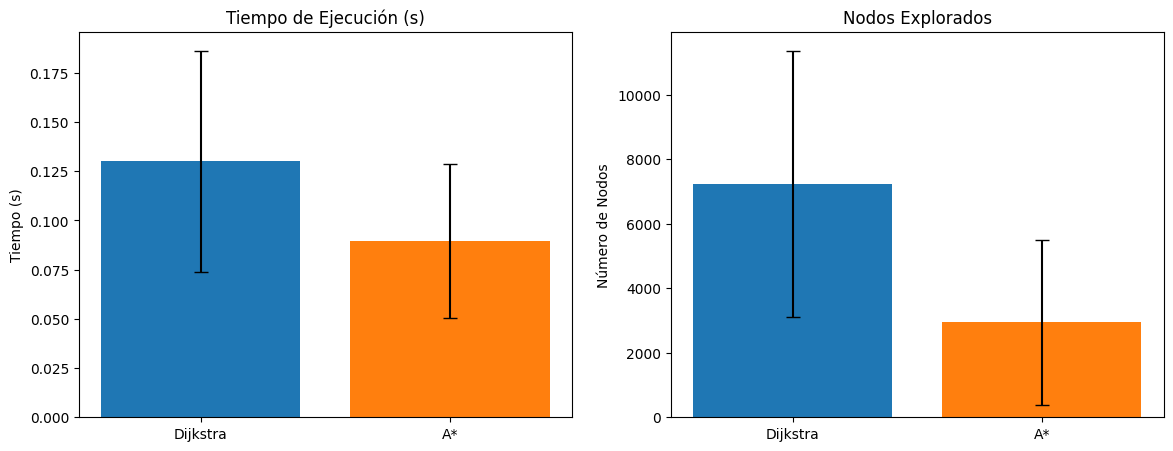

In [25]:
import time
import matplotlib.pyplot as plt
import numpy as np


n_runs = 100


for _ in range(n_runs):
    # Medición para Dijkstra
    source, target = random.choice(list(G.nodes)), random.choice(list(G.nodes))
    
    # Medición para Dijkstra
    start_time = time.time()
    path_dijkstra, explored_nodes_dijkstra, dist_dijkstra, avg_speed_dijkstra, total_time_dijkstra = dijkstra_modified(source, target, plot=False)
    elapsed_time_dijkstra = time.time() - start_time
    results['Dijkstra']['times'].append(elapsed_time_dijkstra)
    results['Dijkstra']['explored_nodes'].append(explored_nodes_dijkstra)
    results['Dijkstra']['distances'].append(dist_dijkstra)
    results['Dijkstra']['avg_speeds'].append(avg_speed_dijkstra)
    results['Dijkstra']['total_times'].append(total_time_dijkstra)
    
    # Medición para A*
    start_time = time.time()
    path_astar, explored_nodes_astar, dist_astar, avg_speed_astar, total_time_astar = a_star_modified(source, target, plot=False)
    elapsed_time_astar = time.time() - start_time
    results['A*']['times'].append(elapsed_time_astar)
    results['A*']['explored_nodes'].append(explored_nodes_astar)
    results['A*']['distances'].append(dist_astar)
    results['A*']['avg_speeds'].append(avg_speed_astar)
    results['A*']['total_times'].append(total_time_astar)

# Función para calcular promedio y desviación estándar
def mean_and_std(values):
    return np.mean(values), np.std(values)

# Visualización de los resultados
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Tiempos de ejecución
times_dijkstra = [mean_and_std(results['Dijkstra']['times'])]
times_astar = [mean_and_std(results['A*']['times'])]

axs[0].bar('Dijkstra', times_dijkstra[0][0], yerr=times_dijkstra[0][1], capsize=5)
axs[0].bar('A*', times_astar[0][0], yerr=times_astar[0][1], capsize=5)
axs[0].set_title('Tiempo de Ejecución (s)')
axs[0].set_ylabel('Tiempo (s)')

# Nodos explorados
explored_dijkstra = [mean_and_std(results['Dijkstra']['explored_nodes'])]
explored_astar = [mean_and_std(results['A*']['explored_nodes'])]

axs[1].bar('Dijkstra', explored_dijkstra[0][0], yerr=explored_dijkstra[0][1], capsize=5)
axs[1].bar('A*', explored_astar[0][0], yerr=explored_astar[0][1], capsize=5)
axs[1].set_title('Nodos Explorados')
axs[1].set_ylabel('Número de Nodos')


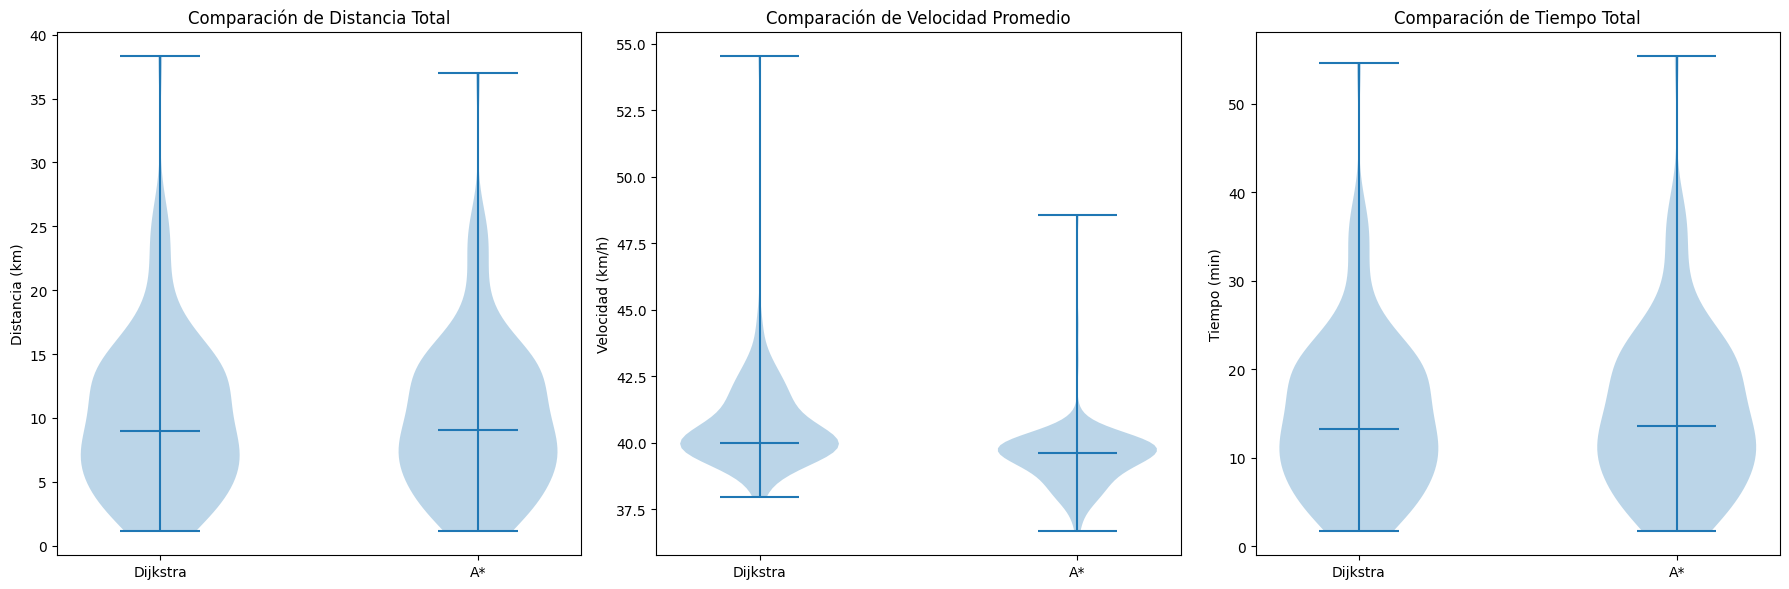

In [32]:
# Prepara los datos para los diagramas de violín
distances = [results['Dijkstra']['distances'], results['A*']['distances']]
avg_speeds = [results['Dijkstra']['avg_speeds'], results['A*']['avg_speeds']]
total_times = [results['Dijkstra']['total_times'], results['A*']['total_times']]

# Asigna figuras y ejes para los gráficos
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Diagrama de violín para Distancias
axs[0].violinplot(distances, showmeans=False, showmedians=True)
axs[0].set_title('Comparación de Distancia Total')
axs[0].set_ylabel('Distancia (km)')
axs[0].set_xticks([1, 2])
axs[0].set_xticklabels(['Dijkstra', 'A*'])

# Diagrama de violín para Velocidades Promedio
axs[1].violinplot(avg_speeds, showmeans=False, showmedians=True)
axs[1].set_title('Comparación de Velocidad Promedio')
axs[1].set_ylabel('Velocidad (km/h)')
axs[1].set_xticks([1, 2])
axs[1].set_xticklabels(['Dijkstra', 'A*'])

# Diagrama de violín para Tiempos Totales
axs[2].violinplot(total_times, showmeans=False, showmedians=True)
axs[2].set_title('Comparación de Tiempo Total')
axs[2].set_ylabel('Tiempo (min)')
axs[2].set_xticks([1, 2])
axs[2].set_xticklabels(['Dijkstra', 'A*'])

plt.tight_layout()
plt.show()


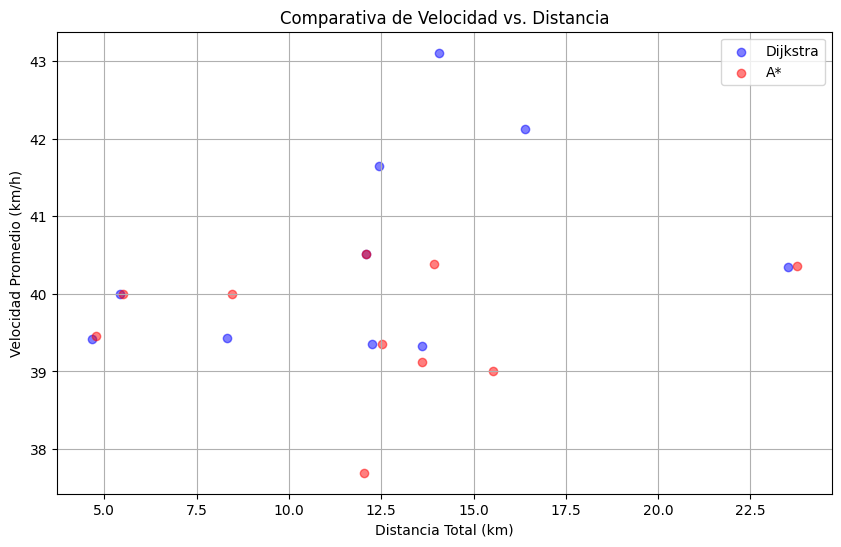

In [22]:
import matplotlib.pyplot as plt

# Datos de distancia y velocidad promedio para Dijkstra y A*
distances_dijkstra = results['Dijkstra']['distances']
avg_speeds_dijkstra = results['Dijkstra']['avg_speeds']
distances_astar = results['A*']['distances']
avg_speeds_astar = results['A*']['avg_speeds']

# Crear gráfico de dispersión
plt.figure(figsize=(10, 6))
plt.scatter(distances_dijkstra, avg_speeds_dijkstra, color='blue', alpha=0.5, label='Dijkstra')
plt.scatter(distances_astar, avg_speeds_astar, color='red', alpha=0.5, label='A*')

# Añadir títulos y etiquetas
plt.title('Comparativa de Velocidad vs. Distancia')
plt.xlabel('Distancia Total (km)')
plt.ylabel('Velocidad Promedio (km/h)')
plt.legend()
plt.grid(True)

plt.show()



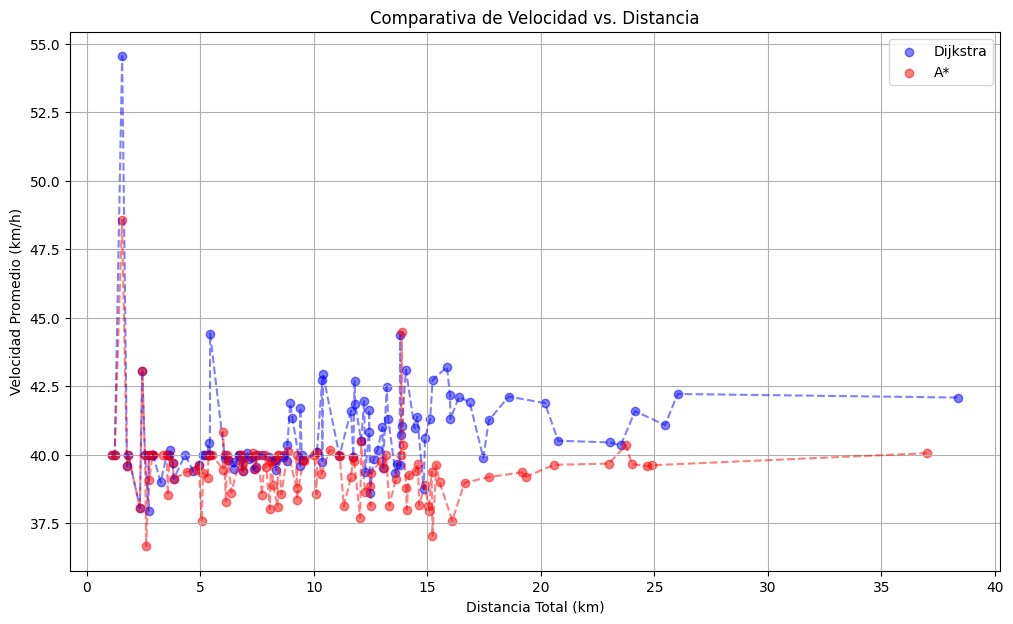

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Ordenar los datos de Dijkstra y A* por distancia
sorted_indices_dijkstra = np.argsort(distances_dijkstra)
sorted_distances_dijkstra = np.array(distances_dijkstra)[sorted_indices_dijkstra]
sorted_avg_speeds_dijkstra = np.array(avg_speeds_dijkstra)[sorted_indices_dijkstra]

sorted_indices_astar = np.argsort(distances_astar)
sorted_distances_astar = np.array(distances_astar)[sorted_indices_astar]
sorted_avg_speeds_astar = np.array(avg_speeds_astar)[sorted_indices_astar]

# Crear gráfico de dispersión con líneas
plt.figure(figsize=(12, 7))
plt.scatter(sorted_distances_dijkstra, sorted_avg_speeds_dijkstra, color='blue', alpha=0.5, label='Dijkstra')
plt.plot(sorted_distances_dijkstra, sorted_avg_speeds_dijkstra, color='blue', alpha=0.5, linestyle='--')

plt.scatter(sorted_distances_astar, sorted_avg_speeds_astar, color='red', alpha=0.5, label='A*')
plt.plot(sorted_distances_astar, sorted_avg_speeds_astar, color='red', alpha=0.5, linestyle='--')

# Añadir títulos y etiquetas
plt.title('Comparativa de Velocidad vs. Distancia')
plt.xlabel('Distancia Total (km)')
plt.ylabel('Velocidad Promedio (km/h)')
plt.legend()
plt.grid(True)

plt.show()


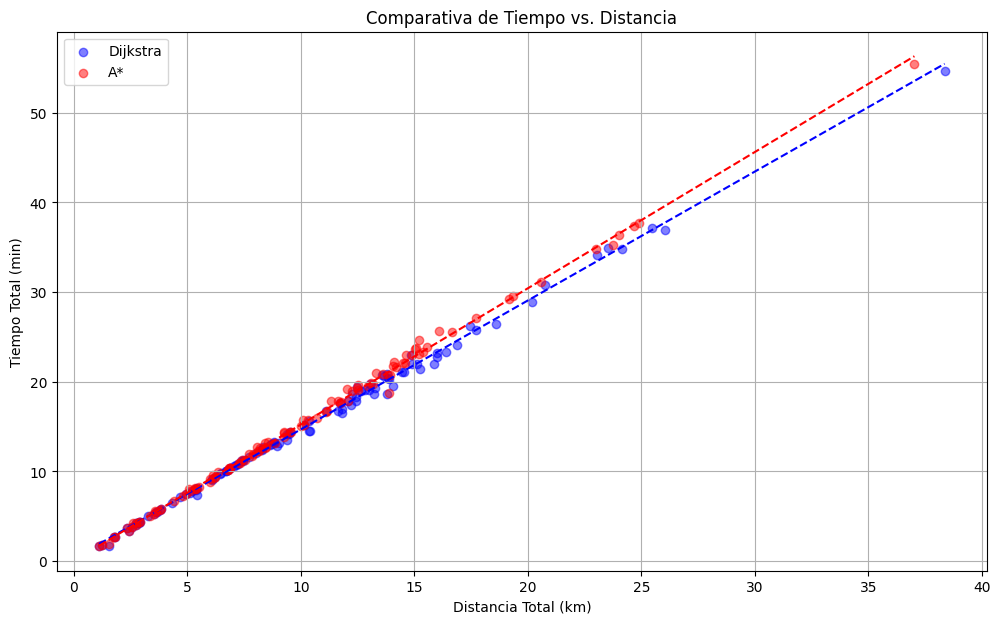

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Datos de distancia y tiempo total para Dijkstra y A*
distances_dijkstra = results['Dijkstra']['distances']
total_times_dijkstra = results['Dijkstra']['total_times']
distances_astar = results['A*']['distances']
total_times_astar = results['A*']['total_times']

# Ordenar los datos por distancia para Dijkstra
sorted_indices_dijkstra = np.argsort(distances_dijkstra)
sorted_distances_dijkstra = np.array(distances_dijkstra)[sorted_indices_dijkstra]
sorted_total_times_dijkstra = np.array(total_times_dijkstra)[sorted_indices_dijkstra]

# Ordenar los datos por distancia para A*
sorted_indices_astar = np.argsort(distances_astar)
sorted_distances_astar = np.array(distances_astar)[sorted_indices_astar]
sorted_total_times_astar = np.array(total_times_astar)[sorted_indices_astar]

# Crear gráfico de dispersión
plt.figure(figsize=(12, 7))
plt.scatter(sorted_distances_dijkstra, sorted_total_times_dijkstra, color='blue', alpha=0.5, label='Dijkstra')
plt.scatter(sorted_distances_astar, sorted_total_times_astar, color='red', alpha=0.5, label='A*')

# Añadir líneas de mejor ajuste
z_dijkstra = np.polyfit(sorted_distances_dijkstra, sorted_total_times_dijkstra, 1)
p_dijkstra = np.poly1d(z_dijkstra)
plt.plot(sorted_distances_dijkstra, p_dijkstra(sorted_distances_dijkstra), "b--")

z_astar = np.polyfit(sorted_distances_astar, sorted_total_times_astar, 1)
p_astar = np.poly1d(z_astar)
plt.plot(sorted_distances_astar, p_astar(sorted_distances_astar), "r--")

# Añadir títulos y etiquetas
plt.title('Comparativa de Tiempo vs. Distancia')
plt.xlabel('Distancia Total (km)')
plt.ylabel('Tiempo Total (min)')
plt.legend()
plt.grid(True)

plt.show()
